In [ ]:
#vibo: Виталий_Бочаров_56089805 ТЕЛЕГРАММ @vibo22

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>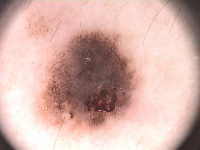</td><td>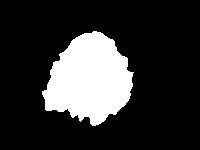</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

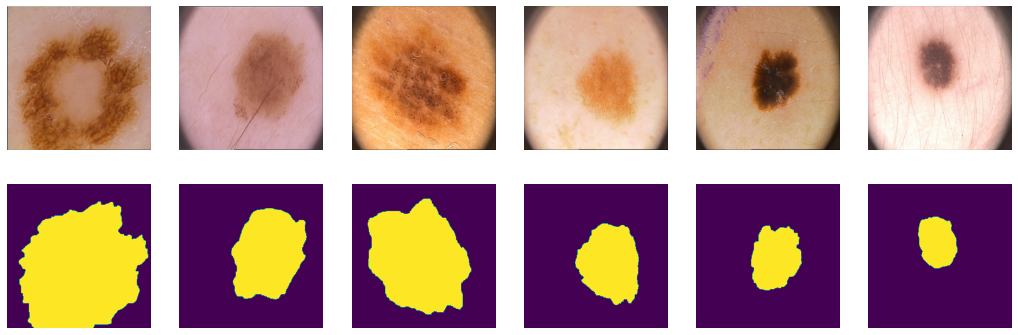

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
#vibo:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
!nvidia-smi

Sun Dec 12 19:06:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

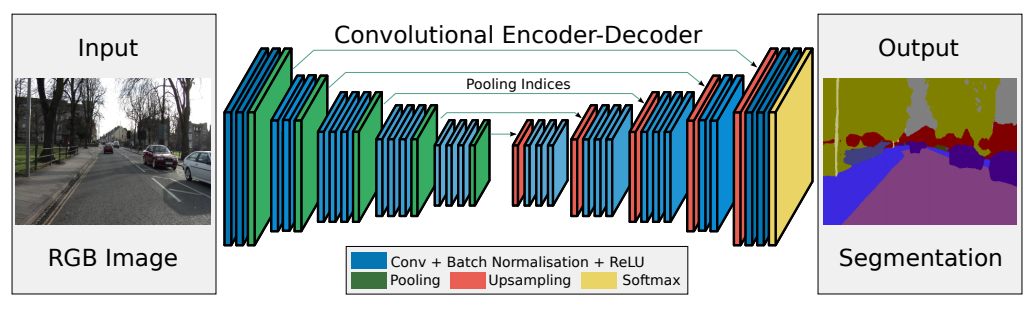

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
#vibo:первое задание - реализуем класс SegNet
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        # self.enc_conv0 = 
        # self.pool0 =   # 256 -> 128
        # self.enc_conv1 = 
        # self.pool1 =  # 128 -> 64
        # self.enc_conv2 = 
        # self.pool2 =  # 64 -> 32
        # self.enc_conv3 =
        # self.pool3 =  # 32 -> 16

        #vibo: делаем encoder (downsampling)

        #vibo: слой0-conv0 -> 2*(Conv2d+BatchNorm+ReLU)
        self.enc_conv0 = nn.Sequential(
                                          #vibo: in_channels=3 изображение rgb
                                          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(inplace=True)
                                      )
        #vibo: слой0-pool0 -> свертка 256х256 pixel -> 128х128 pixel
        #self.pool0 = F.max_pool2d(kernel_size=2, stride=2, padding=0, return_indices = True) 
        
        #vibo: слой1-conv1 -> 2*(Conv2d+BatchNorm+ReLU)
        self.enc_conv1 = nn.Sequential(
                                          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(inplace=True)
                                        )
        #vibo: слой1-pool1 -> свертка 128х128 pixel -> 64x64 pixel
        #self.pool1 = F.max_pool2d(kernel_size=2, stride=2, padding=0, return_indices = True)

        #vibo: слой2-сonv2 -> 3*(Conv2d+BatchNorm+ReLU)    
        self.enc_conv2 = nn.Sequential(
                                          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(inplace=True)
                                      )
        #vibo: слой2-pool2 -> свертка 64х64 pixel -> 32x32 pixel
        #self.pool2 = F.max_pool2d(kernel_size=2, stride=2, padding=0, return_indices = True) 
        
        #vibo: слой3-сonv3 -> 3*(Conv2d+BatchNorm+ReLU)      
        self.enc_conv3 = nn.Sequential(
                                          nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(inplace=True)
                                      )
        #vibo: слой3-pool3 -> свертка 32х32 pixel -> 16x16 pixel        
        #self.pool3 = F.max_pool2d(kernel_size=2, stride=2, padding=0, return_indices = True) 

        # bottleneck

        #vibo: завершаем encoder (downsampling) в bottleneck
        
        #vibo: слой4-bottleneck_conv -> 3*(Conv2d+BatchNorm+ReLU)
        self.bottleneck_conv = nn.Sequential(
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU()
                                            )
        #vibo: слой4-bottleneck_pool -> свертка 16х16 pixel -> 8x8 pixel
        #self.bottleneck_pool = F.max_pool2d(kernel_size=2, stride=2, padding=0, return_indices = True)
        
        #vibo: делаем decoder (upsampling)

        #vibo: слой5-bottleneck_unpool -> 8х8 pixel -> 16x16 pixel
        #self.bottleneck_unpool = F.max_unpool2d(kernel_size=2, stride=2, padding=0)
        
        #vibo: слой5-bottleneck_dec_conv -> 3*(Conv2d+BatchNorm+ReLU)                                      
        self.bottleneck_dec_conv = nn.Sequential(                                      
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU(),
                                              nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                              nn.BatchNorm2d(512),
                                              nn.ReLU()                                             
                                            )

        # decoder (upsampling)
        # self.upsample0 =  # 16 -> 32
        # self.dec_conv0 = 
        # self.upsample1 =  # 32 -> 64
        # self.dec_conv1 = 
        # self.upsample2 =   # 64 -> 128
        # self.dec_conv2 = 
        # self.upsample3 =   # 128 -> 256
        # self.dec_conv3 =

        #vibo: продолжаем делать decoder (upsampling)
        
        #vibo: слой0-upsample0 -> 16x16 pixel -> 32x32 pixel
        #self.upsample0 = F.max_unpool2d(kernel_size=2, stride=2, padding=0)
        #vibo: слой0-dec_conv0 -> 3*(ConvTranspose2d+BatchNorm2d+ReLU)
        self.dec_conv0 = nn.Sequential(
                                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU()                                         
                                      )
        
        #vibo: слой1-upsample1 -> 32x32 pixel -> 64x64 pixel
        #self.upsample1 = F.max_unpool2d(kernel_size=2, stride=2, padding=0)
        #vibo: cлой1-dec_conv1 -> 3*(ConvTranspose2d+BatchNorm2d+ReLU)
        self.dec_conv1 = nn.Sequential(
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(256),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(),                                       
                                      )
        #vibo: слой2-upsample2 -> 64x64 pixel -> 128x128 pixel
        #self.upsample2 = F.max_unpool2d(kernel_size=2, stride=2, padding=0)
        #vibo: слой2-dec_conv2 -> 2*(ConvTranspose2d+BatchNorm2d+ReLU)
        self.dec_conv2 = nn.Sequential(
                                          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(),
                                      )
        #vibo: слой3-upsample3, 128x128 pixel -> 256x256 pixel
        #self.upsample3 = F.max_unpool2d(kernel_size=2, stride=2, padding=0)
        #vibo: cлой3-dec_conv3 -> (ConvTranspose2d+BatchNorm2d+ReLU) + (ConvTranspose2d) БЕЗ!!! BatchNorm2d+ReLU
        self.dec_conv3 = nn.Sequential(
                                          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(),
                                          #vibo: out_channels=1 изображение ч/б
                                          nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
                                       )

    def forward(self, x):
        # encoder
        
        #vibo: заходим в encoder 
        #vibo: слой0-conv0
        e0 = self.enc_conv0(x)
        #vibo: слой0-pool0, забираем indices pool слоя для использования в decoder
        #x0e, id0e = self.pool0(e0)
        x0e, id0e = F.max_pool2d(e0, kernel_size=2, stride=2, padding=0, return_indices = True)
        
        #vibo: слой1-conv1
        e1 = self.enc_conv1(x0e)
        #vibo: слой1-pool1, забираем indices pool слоя для использования в decoder
        #x1e, id1e = self.pool1(e1)
        x1e, id1e = F.max_pool2d(e1, kernel_size=2, stride=2, padding=0, return_indices = True)
        
        #vibo: слой2-conv2
        e2 = self.enc_conv2(x1e)
        #vibo: слой2-pool2, забираем indices pool слоя для использования в decoder  
        #x2e, id2e = self.pool2(e2)
        x2e, id2e = F.max_pool2d(e2, kernel_size=2, stride=2, padding=0, return_indices = True)
        
        #vibo: слой3-conv3
        e3 = self.enc_conv3(x2e)
        #vibo: слой3-pool3, забираем indices pool слоя для использования в decoder
        #x3e, id3e = self.pool3(e3)
        x3e, id3e = F.max_pool2d(e3, kernel_size=2, stride=2, padding=0, return_indices = True)

        # bottleneck
        
        #vibo: заходим в bottleneck

        #vibo: слой4-bottleneck_conv
        b = self.bottleneck_conv(x3e)
        #vibo: слой4-bottleneck_pool, забираем indices pool слоя для использования в decoder  
        #x4e, id4e = self.bottleneck_pool(b)
        x4e, id4e = F.max_pool2d(b, kernel_size=2, stride=2, padding=0, return_indices = True)

        #vibo: идем в обратную сторону, decoder (upsampling)

        #vibo: слой5-bottleneck_unpool
        b_unpool = F.max_unpool2d(x4e, id4e, kernel_size=2, stride=2, padding=0)
        #vibo: слой5-bottleneck_dec_conv
        b_up = self.bottleneck_dec_conv(b_unpool)

        # decoder

        #vibo: продолжаем идти по decoder
        
        #vibo: слой0-upsample0
        x0d = F.max_unpool2d(b_up, id3e, kernel_size=2, stride=2, padding=0)
        #vibo:слой0-dec_conv0
        d0 = self.dec_conv0(x0d)
                
        #vibo: слой1-upsample1
        x1d = F.max_unpool2d(d0, id2e, kernel_size=2, stride=2, padding=0)
        #vibo: cлой1-dec_conv1
        d1 = self.dec_conv1(x1d)

        #vibo: слой2-upsample2
        x2d = F.max_unpool2d(d1, id1e, kernel_size=2, stride=2, padding=0)
        #vibo: слой2-dec_conv2
        d2 = self.dec_conv2(x2d)

        #vibo: слой3-upsample3
        x3d = F.max_unpool2d(d2, id0e, kernel_size=2, stride=2, padding=0)
        #vibo: cлой3-dec_conv3
        d3 = self.dec_conv3(x3d)  # no activation
        return d3

In [ ]:
#vibo: проверяем модель
model = SegNet().to(DEVICE)
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
       BatchNorm2d-8        [-1, 128, 128, 128]             256
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
      BatchNorm2d-14          [-1, 256,

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
#vibo: base_line / заданная метрика для оценки качества iou_pytorch, описание выше

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    #return thresholded  #
    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
#vibo: второе задание - реализация функции потерь 
#def bce_loss(y_real, y_pred):
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    
    #vibo: простое усреднение (работает с погрешностью в 4 знаке после запятой)
    #res = (y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))).mean()
    #vibo: поканальное усреднение (работает точнее)
    res = (torch.mean((y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))), (0, 1, 2))).mean()
   
    #vibo: проверка через модуль BCEWithLogitsLoss
    #res = nn.BCEWithLogitsLoss()(y_real, y_pred)
    return res

In [ ]:
#vibo: проверка функции потерь bce_loss
t1 = torch.randn(64, 1, 256, 256)
t2 = torch.randn(64, 1, 256, 256)
print(nn.BCEWithLogitsLoss()(t1, t2))
print(bce_loss(t1, t2))

tensor(0.8061)
tensor(0.8061)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
#vibo: задание три - дописываем функцию обучения2

def train(model, opt, loss_fn, epochs, data_tr, data_val):   
    X_val, Y_val = next(iter(data_val))
    #vibo: для записи результатов
    losses_train = []
    losses_val = []
    losses_test = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        avg_loss_val = 0
        avg_loss_test = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:            
            # data to device
            #vibo: переносим данные на device
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)                              
            # set parameter gradients to zero
            #vibo: обнуляем градиенты
            opt.zero_grad()            
            # forward
            #vibo: предсказание модели (логиты, последний слой без ReLU)
            Y_pred = model(X_batch)          
            #vibo: вычисляем функцию потерь
            loss = loss_fn(Y_pred, Y_batch)
            #vibo: записываем loss
            loss.detach().item()
            # forward-pass            
            #vibo:вычисляем градиенты
            loss.backward()  # backward-pass            
            #vibo: обновляем веса модели
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            #vibo: чиним "CUDA out of memory"
            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            Y_pred = Y_pred.cpu()
            del X_batch, Y_batch, Y_pred
            torch.cuda.empty_cache()
        toc = time()
        print('loss_train: %f' % avg_loss)                    
        #vibo:
        losses_train.append(avg_loss)
        # show intermediate results
        
        model.eval()  # testing mode        
        #vibo: предсказания на val батче
        X_val = X_val.to(DEVICE)
        Y_val = Y_val.to(DEVICE)
        #vibo:
        Y_hat = model(X_val).detach()
        X_val = X_val.cpu() # detach and put into cpu
        Y_hat = Y_hat.cpu()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss_train: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        #vibo: добавляем цикл для оценки качества модели на валидации
        for X_batch, Y_batch in data_val:            
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)                              
            with torch.no_grad():       
              Y_pred_val = model(X_batch)          
              loss_val = loss_fn(Y_pred_val, Y_batch)
              avg_loss_val += loss_val / len(data_val)
              
              X_batch = X_batch.cpu()
              Y_batch = Y_batch.cpu()
              Y_pred_val = Y_pred_val.cpu()
              del X_batch, Y_batch, Y_pred_val
              torch.cuda.empty_cache()

        toc = time()
        print('loss_val: %f' % avg_loss_val)                    
        losses_val.append(avg_loss_val)

        #vibo: добавляем цикл для оценки качества модели на тесте
        for X_batch, Y_batch in data_ts:            
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)                              
            with torch.no_grad():       
              Y_pred_test = model(X_batch)          
              loss_test = loss_fn(Y_pred_test, Y_batch)
              avg_loss_test += loss_test / len(data_ts)
              
              X_batch = X_batch.cpu()
              Y_batch = Y_batch.cpu()
              Y_pred_test = Y_pred_test.cpu()
              del X_batch, Y_batch, Y_pred_test
              torch.cuda.empty_cache()

        toc = time()
        print('loss_test: %f' % avg_loss_test)                    
        losses_test.append(avg_loss_test)

    #vibo:
    return losses_train, losses_val, losses_test

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
#vibo: задание четыре - дописываем функцию оценки качества модели
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        #vibo: предсказание модели (логиты, последний слой без ReLU)
        #vibo: не обновляем градиенты
        with torch.no_grad():
          Y_pred = model(X_batch.to(DEVICE))

          #vibo: делаем бинаризацию предсказаний
          Y_pred = torch.round(torch.sigmoid(Y_pred))

          scores += metric(Y_pred, Y_label.to(DEVICE)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


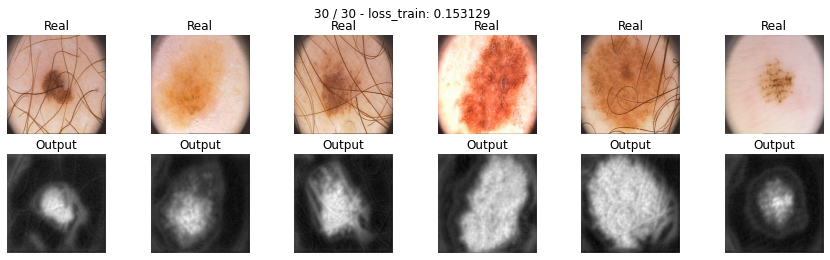

loss_val: 0.159659
loss_test: 0.158725


In [ ]:
#vibo: задание пять - обучаем модель
model = SegNet().to(DEVICE)
max_epochs = 30
opt = torch.optim.Adam(model.parameters(), lr = 3e-4)
losses_train, losses_val, losses_test = train(model, opt, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
!nvidia-smi

Sun Dec 12 19:35:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    73W / 149W |   8328MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Dec 12 19:35:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |   6022MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#vibo: score модели на валидации
val_score = round(score_model(model, iou_pytorch, data_val), 4)
print('val_score:', val_score)
#vibo: score модели на тесте
test_score = round(score_model(model, iou_pytorch, data_ts), 4)
print('test_score:', test_score)

val_score: 0.806
test_score: 0.834


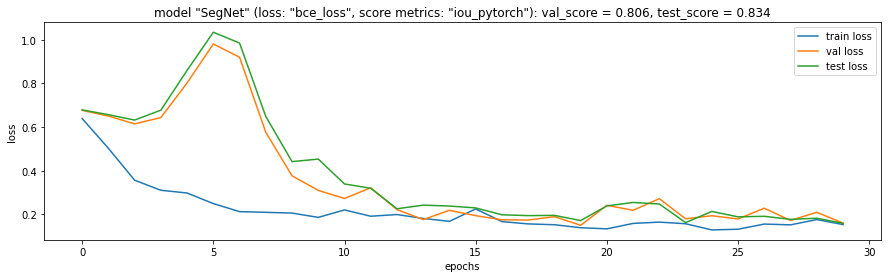

In [ ]:
#vibo: строим графики
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.plot(losses_test, label = 'test loss')
plt.title(f'model "SegNet" (loss: "bce_loss", score metrics: "iou_pytorch"): val_score = {val_score}, test_score = {test_score}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#vibo: для отчета:
SegNet_bce_loss_val_loss = losses_val
print(SegNet_bce_loss_val_loss)

SegNet_bce_loss_test_loss = losses_test
print(SegNet_bce_loss_test_loss)

SegNet_bce_loss_val_score = val_score
print(SegNet_bce_loss_val_score)

SegNet_bce_loss_test_score = test_score
print(SegNet_bce_loss_test_score)

[tensor(0.6767, device='cuda:0'), tensor(0.6506, device='cuda:0'), tensor(0.6147, device='cuda:0'), tensor(0.6433, device='cuda:0'), tensor(0.8022, device='cuda:0'), tensor(0.9810, device='cuda:0'), tensor(0.9203, device='cuda:0'), tensor(0.5759, device='cuda:0'), tensor(0.3767, device='cuda:0'), tensor(0.3097, device='cuda:0'), tensor(0.2727, device='cuda:0'), tensor(0.3218, device='cuda:0'), tensor(0.2217, device='cuda:0'), tensor(0.1760, device='cuda:0'), tensor(0.2183, device='cuda:0'), tensor(0.1939, device='cuda:0'), tensor(0.1749, device='cuda:0'), tensor(0.1738, device='cuda:0'), tensor(0.1894, device='cuda:0'), tensor(0.1496, device='cuda:0'), tensor(0.2413, device='cuda:0'), tensor(0.2186, device='cuda:0'), tensor(0.2716, device='cuda:0'), tensor(0.1795, device='cuda:0'), tensor(0.1935, device='cuda:0'), tensor(0.1788, device='cuda:0'), tensor(0.2279, device='cuda:0'), tensor(0.1720, device='cuda:0'), tensor(0.2094, device='cuda:0'), tensor(0.1597, device='cuda:0')]
[tensor(0

Ответьте себе на вопрос: не переобучается ли моя модель?

In [ ]:
#vibo: модель не переобучается

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
#vibo: задание семь - функция DICE
def dice_loss(y_pred, y_real):
    SMOOTH = 1e-8
    y_pred = torch.sigmoid(y_pred)
    num = 2.*torch.sum((y_real*y_pred), (1, 2, 3)) + SMOOTH
    den = torch.sum(y_real, (1, 2, 3)) + torch.sum(y_pred, (1, 2, 3)) + SMOOTH 
    res = 1 - (num/den).mean()
    return res

Проводим тестирование:

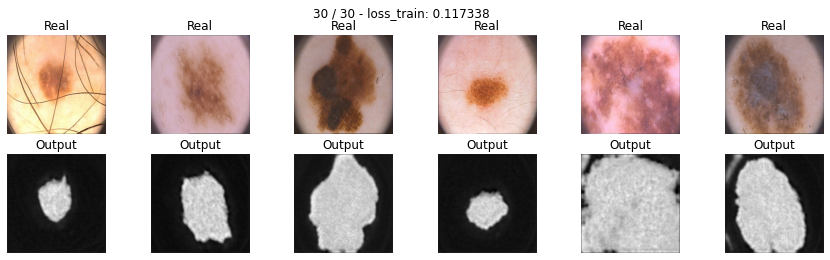

loss_val: 0.135954
loss_test: 0.121437


In [ ]:
#vibo: обучаем модель
model_dice = SegNet().to(DEVICE)
max_epochs = 30
#max_epochs = 40
opt = torch.optim.Adam(model_dice.parameters(), lr = 3e-4)
losses_train, losses_val, losses_test = train(model_dice, opt, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
#vibo: score модели на валидации
val_score = round(score_model(model_dice, iou_pytorch, data_val), 4)
print('val_score:', val_score)
#vibo: score модели на тесте
test_score = round(score_model(model_dice, iou_pytorch, data_ts), 4)
print('test_score:', test_score)

val_score: 0.7906
test_score: 0.8114


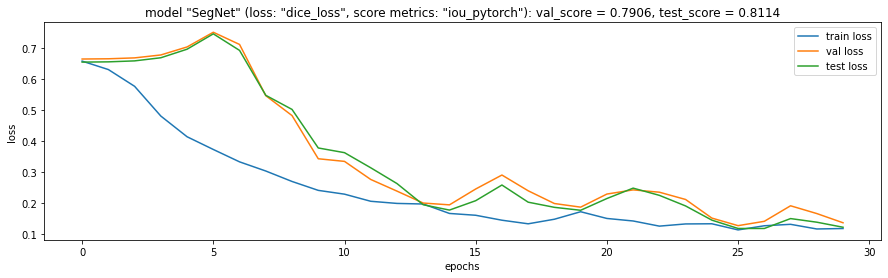

In [ ]:
#vibo: строим графики
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.plot(losses_test, label = 'test loss')
plt.title(f'model "SegNet" (loss: "dice_loss", score metrics: "iou_pytorch"): val_score = {val_score}, test_score = {test_score}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#vibo: для отчета:
SegNet_dice_loss_val_loss = losses_val
print(SegNet_dice_loss_val_loss)

SegNet_dice_loss_test_loss = losses_test
print(SegNet_dice_loss_test_loss)

SegNet_dice_loss_val_score = val_score
print(SegNet_dice_loss_val_score)

SegNet_dice_loss_test_score = test_score
print(SegNet_dice_loss_test_score)

[tensor(0.6659, device='cuda:0'), tensor(0.6667, device='cuda:0'), tensor(0.6696, device='cuda:0'), tensor(0.6791, device='cuda:0'), tensor(0.7050, device='cuda:0'), tensor(0.7526, device='cuda:0'), tensor(0.7131, device='cuda:0'), tensor(0.5473, device='cuda:0'), tensor(0.4829, device='cuda:0'), tensor(0.3431, device='cuda:0'), tensor(0.3346, device='cuda:0'), tensor(0.2761, device='cuda:0'), tensor(0.2384, device='cuda:0'), tensor(0.1998, device='cuda:0'), tensor(0.1939, device='cuda:0'), tensor(0.2453, device='cuda:0'), tensor(0.2905, device='cuda:0'), tensor(0.2395, device='cuda:0'), tensor(0.1982, device='cuda:0'), tensor(0.1865, device='cuda:0'), tensor(0.2289, device='cuda:0'), tensor(0.2424, device='cuda:0'), tensor(0.2349, device='cuda:0'), tensor(0.2113, device='cuda:0'), tensor(0.1511, device='cuda:0'), tensor(0.1266, device='cuda:0'), tensor(0.1406, device='cuda:0'), tensor(0.1909, device='cuda:0'), tensor(0.1658, device='cuda:0'), tensor(0.1360, device='cuda:0')]
[tensor(0

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
#vibo: задание восемь - пишем функцию Focal loss
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    #vibo:
    y_pred = torch.sigmoid(y_pred)
    #vibo: 
    your_loss = (1 - torch.exp(-bce_loss(y_real, y_pred)))**gamma * bce_loss(y_real, y_pred)
    return your_loss

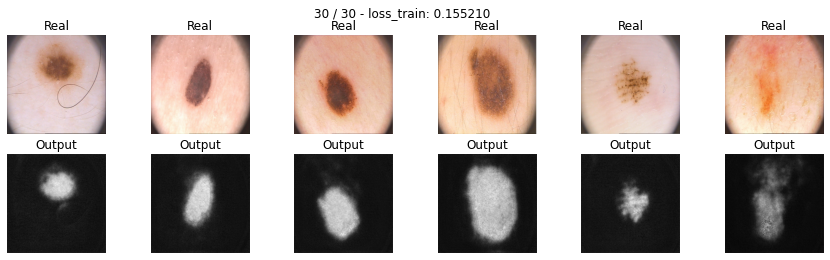

loss_val: 0.158868
loss_test: 0.156776


In [ ]:
#vibo: обучаем модель
model_focal = SegNet().to(DEVICE)
max_epochs = 30
#max_epochs = 40
opt = torch.optim.Adam(model_focal.parameters(), lr = 3e-4)
losses_train, losses_val, losses_test = train(model_focal, opt, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
#vibo: score модели на валидации
val_score = round(score_model(model_focal, iou_pytorch, data_val), 4)
print('val_score:', val_score)
#vibo: score модели на тесте
test_score = round(score_model(model_focal, iou_pytorch, data_ts), 4)
print('test_score:', test_score)

val_score: 0.3495
test_score: 0.3757


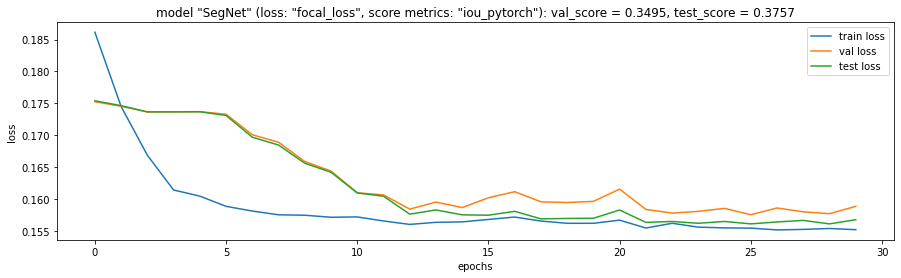

In [ ]:
#vibo: строим графики
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.plot(losses_test, label = 'test loss')
plt.title(f'model "SegNet" (loss: "focal_loss", score metrics: "iou_pytorch"): val_score = {val_score}, test_score = {test_score}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#vibo: для отчета:
SegNet_focal_loss_val_loss = losses_val
print(SegNet_focal_loss_val_loss)

SegNet_focal_loss_test_loss = losses_test
print(SegNet_focal_loss_test_loss)

SegNet_focal_loss_val_score = val_score
print(SegNet_focal_loss_val_score)

SegNet_focal_loss_test_score = test_score
print(SegNet_focal_loss_test_score)

[tensor(0.1753, device='cuda:0'), tensor(0.1745, device='cuda:0'), tensor(0.1737, device='cuda:0'), tensor(0.1737, device='cuda:0'), tensor(0.1737, device='cuda:0'), tensor(0.1733, device='cuda:0'), tensor(0.1701, device='cuda:0'), tensor(0.1689, device='cuda:0'), tensor(0.1659, device='cuda:0'), tensor(0.1644, device='cuda:0'), tensor(0.1610, device='cuda:0'), tensor(0.1607, device='cuda:0'), tensor(0.1584, device='cuda:0'), tensor(0.1595, device='cuda:0'), tensor(0.1587, device='cuda:0'), tensor(0.1602, device='cuda:0'), tensor(0.1612, device='cuda:0'), tensor(0.1596, device='cuda:0'), tensor(0.1595, device='cuda:0'), tensor(0.1596, device='cuda:0'), tensor(0.1616, device='cuda:0'), tensor(0.1584, device='cuda:0'), tensor(0.1578, device='cuda:0'), tensor(0.1581, device='cuda:0'), tensor(0.1586, device='cuda:0'), tensor(0.1576, device='cuda:0'), tensor(0.1586, device='cuda:0'), tensor(0.1580, device='cuda:0'), tensor(0.1577, device='cuda:0'), tensor(0.1589, device='cuda:0')]
[tensor(0

In [ ]:
!nvidia-smi

Sun Dec 12 19:50:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   8332MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Dec 12 19:50:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |   6026MiB / 11441MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
#vibo: реализуем weighted binary cross entropy

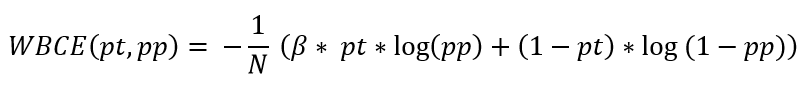

In [ ]:
#vibo: задание девять - пишем функцию wbce
def wbce_loss(y_pred, y_real, betta = 0.5):
    y_pred = torch.sigmoid(y_pred)
    res = (-(betta * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1- y_pred))).mean()
    #res = (torch.mean(0.5 * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1- y_pred)), (0, 1, 2)).mean()
    return res

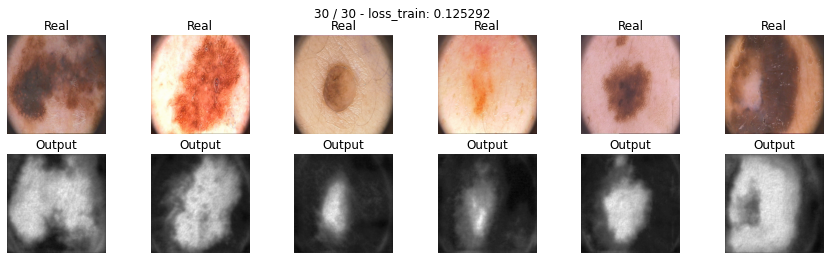

loss_val: 0.144586
loss_test: 0.138629


In [ ]:
#vibo: обучаем модель
model_wbce = SegNet().to(DEVICE)
max_epochs = 30
#max_epochs = 40
opt = torch.optim.Adam(model_wbce.parameters(), lr = 3e-4)
losses_train, losses_val, losses_test = train(model_wbce, opt, wbce_loss, max_epochs, data_tr, data_val)

In [ ]:
#vibo: score модели на валидации
val_score = round(score_model(model_wbce, iou_pytorch, data_val), 4)
print('val_score:', val_score)
#vibo: score модели на тесте
test_score = round(score_model(model_wbce, iou_pytorch, data_ts), 4)
print('test_score:', test_score)

val_score: 0.7406
test_score: 0.7666


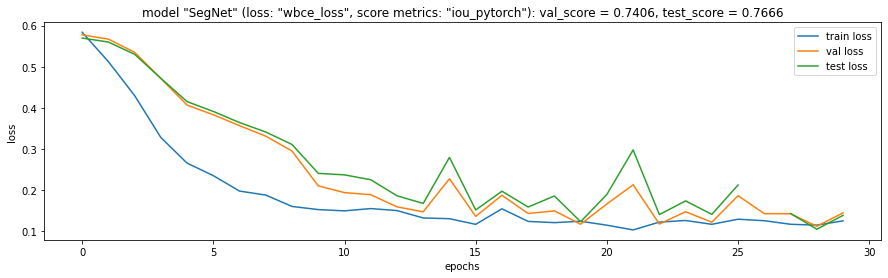

In [ ]:
#vibo: строим графики
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.plot(losses_test, label = 'test loss')
plt.title(f'model "SegNet" (loss: "wbce_loss", score metrics: "iou_pytorch"): val_score = {val_score}, test_score = {test_score}')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#vibo: для отчета:
SegNet_wbce_loss_val_loss = losses_val
print(SegNet_wbce_loss_val_loss)

SegNet_wbce_loss_test_loss = losses_test
print(SegNet_wbce_loss_test_loss)

SegNet_wbce_loss_val_score = val_score
print(SegNet_wbce_loss_val_score)

SegNet_wbce_loss_test_score = test_score
print(SegNet_wbce_loss_test_score)

[tensor(0.5776, device='cuda:0'), tensor(0.5672, device='cuda:0'), tensor(0.5352, device='cuda:0'), tensor(0.4716, device='cuda:0'), tensor(0.4068, device='cuda:0'), tensor(0.3833, device='cuda:0'), tensor(0.3568, device='cuda:0'), tensor(0.3313, device='cuda:0'), tensor(0.2950, device='cuda:0'), tensor(0.2104, device='cuda:0'), tensor(0.1939, device='cuda:0'), tensor(0.1889, device='cuda:0'), tensor(0.1593, device='cuda:0'), tensor(0.1473, device='cuda:0'), tensor(0.2277, device='cuda:0'), tensor(0.1362, device='cuda:0'), tensor(0.1875, device='cuda:0'), tensor(0.1431, device='cuda:0'), tensor(0.1495, device='cuda:0'), tensor(0.1172, device='cuda:0'), tensor(0.1663, device='cuda:0'), tensor(0.2130, device='cuda:0'), tensor(0.1175, device='cuda:0'), tensor(0.1475, device='cuda:0'), tensor(0.1220, device='cuda:0'), tensor(0.1864, device='cuda:0'), tensor(0.1428, device='cuda:0'), tensor(0.1425, device='cuda:0'), tensor(0.1121, device='cuda:0'), tensor(0.1446, device='cuda:0')]
[tensor(0

In [ ]:
!nvidia-smi

Sun Dec 12 20:02:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    76W / 149W |   6030MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Dec 12 20:02:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    76W / 149W |   6030MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

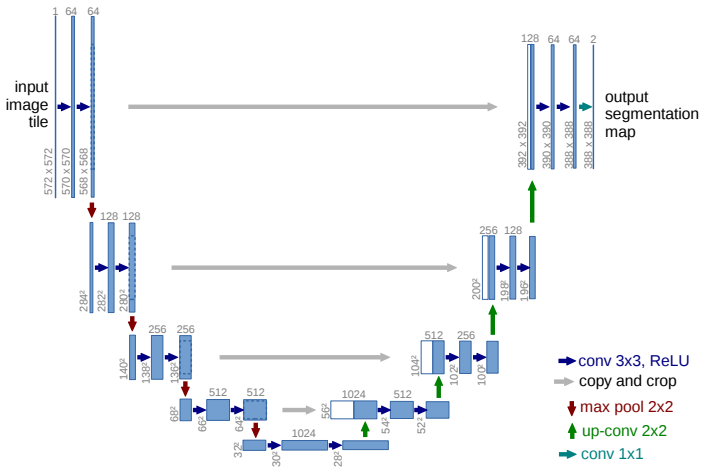

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =
        self.pool0 =   # 256 -> 128
        self.enc_conv1 = 
        self.pool1 =  # 128 -> 64
        self.enc_conv2 = 
        self.pool2 =  # 64 -> 32
        self.enc_conv3 =
        self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = 

        # decoder (upsampling)
        self.upsample0 =  # 16 -> 32
        self.dec_conv0 = 
        self.upsample1 =  # 32 -> 64
        self.dec_conv1 = 
        self.upsample2 =   # 64 -> 128
        self.dec_conv2 = 
        self.upsample3 =   # 128 -> 256
        self.dec_conv3 =

    def forward(self, x):
        # encoder
        e0 =
        e1 = 
        e2 = 
        e3 =

        # bottleneck
        b = 

        # decoder
        d0 = 
        d1 = 
        d2 = 
        d3 =   # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):

In [ ]:
unet2_model = UNet2().to(device)

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [ ]:
#vibo: Виталий_Бочаров_56089805 ТЕЛЕГРАММ @vibo22
#vibo: отчет о проделанной работе ниже



---



---


### *Отчет о проделанной работе на тему*: **Сегментация изображений**



В ходе выполнения домашнего задания решалась задача **сегментации изображений**, медицинских снимков датасета ADDI project (фотографии двух типов поражений кожи: меланома и родинки). Исходные изображения имели разные размеры и были приведены к размеру на 256×256 пикселей, а также нормализованы в диапазоне [0,1]. Исходные 200 изображений были разделены на три части (100/50/50) для обучения, валидации и теста соответственно. 

В качестве **архитектуры** для решения задачи семантической сегментации реализована **SegNet** (semantic segmentation model) со следующими основными параметрами:


*   Total params: 29,443,585
*   Trainable params: 29,443,585
*   Non-trainable params: 0
*   Input size (MB): 0.75
*   Forward/backward pass size (MB): 672.50
*   Params size (MB): 112.32
*   Estimated Total Size (MB): 785.57

В качестве **метрики** для измерения качества сегментации была применена метрика **Intersection over Union (IoU)** - число от 0 до 1, показывающее, насколько совпадают два объекта (эталон и текущий), далее score. Ожидаемый score в соответствии с полученными рекомендациями для 30 эпох обучения - 0.75-0.80.

В качестве **функции потерь** для задачи бинарной семантической сегментации рассмотрены следующие:


1.   Binary cross entropy (BCE) - бинарная кросс-энтропия;
2.   Dice coefficient;
3.   Focal loss;
4.   Weighted binary cross entropy (WBCE) - взвешенная бинарная кросс-энтропия.






В качестве **оптимизатора** при обучении моделей использован Adam с шагом обучения lr = 3e-4.

### 1. Binary cross entropy (BCE)
В ходе обучения модели SegNet c применением в качесте функции потерь Binary cross entropy (BCE) - бинарной кросс-энтропии получены следующие результаты:


1.   val_score = 0.806
2.   test_score = 0.834



График обучения модели, зависимость функции потерь на обучающей выборке (train_loss), а также зависимости функции потерь на валидационной (val_loss) и отложенной тестовой (test_loss) выборках от количества эпох обучения приведен ниже.

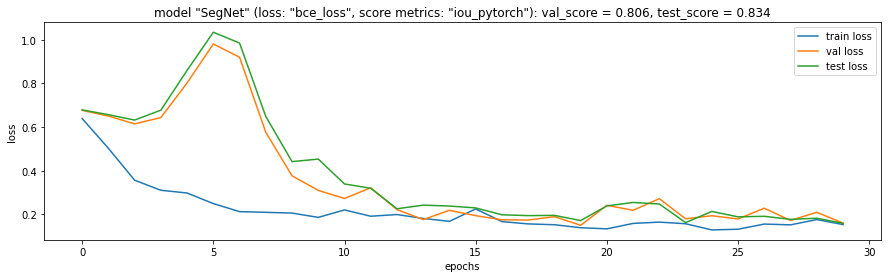

### 2. Dice coefficient
В ходе обучения модели SegNet c применением в качесте функции потерь Dice coefficient получены следующие результаты:


1.   val_score = 0.7906
2.   test_score = 0.8114

График обучения модели, зависимость функции потерь на обучающей выборке (train_loss), а также зависимости функции потерь на валидационной (val_loss) и отложенной тестовой (test_loss) выборках от количества эпох обучения приведен ниже.

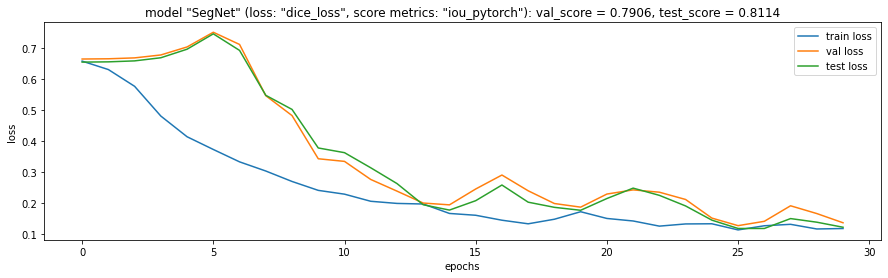

### 3. Focal loss
В ходе обучения модели SegNet c применением в качесте функции потерь Focal loss получены следующие результаты:


1.   val_score = 0.3495
2.   test_score = 0.3757

График обучения модели, зависимость функции потерь на обучающей выборке (train_loss), а также зависимости функции потерь на валидационной (val_loss) и отложенной тестовой (test_loss) выборках от количества эпох обучения приведен ниже.

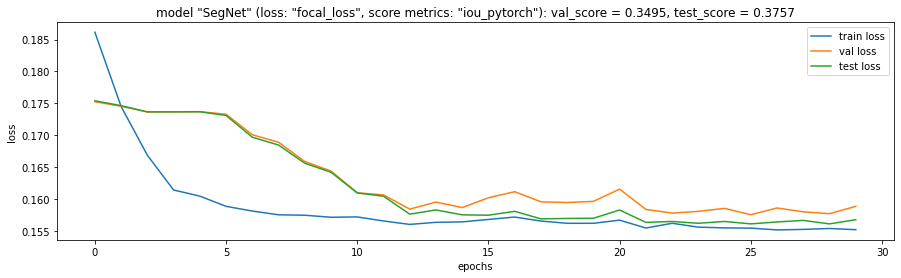

### 4. Weighted binary cross entropy (WBCE)
В ходе обучения модели SegNet c применением в качесте функции потерь Weighted binary cross entropy (WBCE) - взвешенной бинарной кросс-энтропии получены следующие результаты:


1.   val_score = 0.7406
2.   test_score = 0.7666

График обучения модели, зависимость функции потерь на обучающей выборке (train_loss), а также зависимости функции потерь на валидационной (val_loss) и отложенной тестовой (test_loss) выборках от количества эпох обучения приведен ниже.

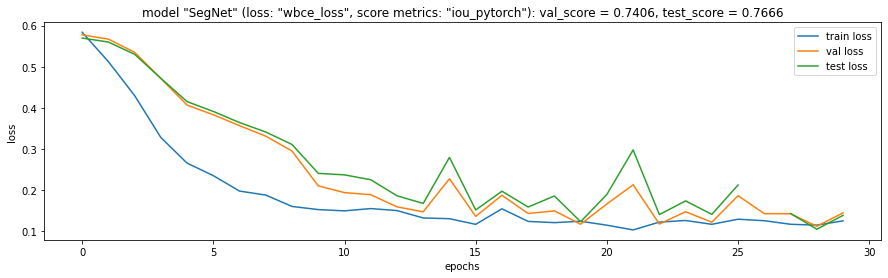

Для сравнения ниже приведены графики функций потерь (bce_loss, dice_loss, focal_loss, wbce_loss) от количества эпох, оцененных на валидационной выборке.

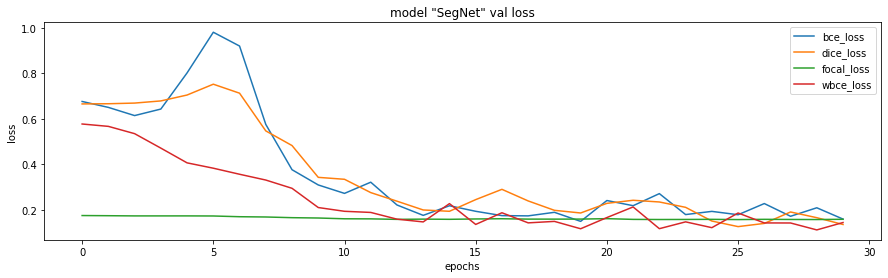

In [ ]:
#vibo: строим графики losses на val
plt.plot(SegNet_bce_loss_val_loss, label = 'bce_loss')
plt.plot(SegNet_dice_loss_val_loss, label = 'dice_loss')
plt.plot(SegNet_focal_loss_val_loss, label = 'focal_loss')
plt.plot(SegNet_wbce_loss_val_loss, label = 'wbce_loss')
plt.title(f'model "SegNet" val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Для сравнения ниже приведены графики функций потерь (bce_loss, dice_loss, focal_loss, wbce_loss) от количества эпох, оцененных на отложенной тестовой выборке.

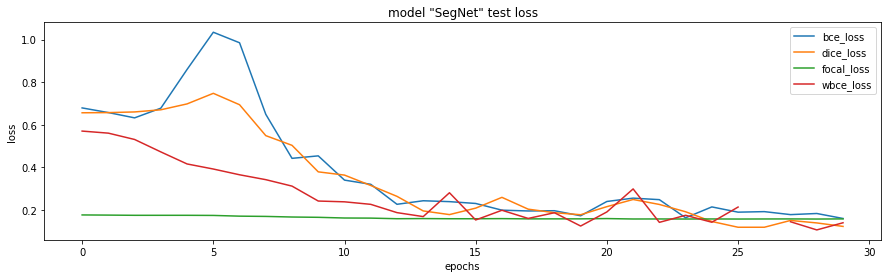

In [ ]:
#vibo: строим графики losses на test
plt.plot(SegNet_bce_loss_test_loss, label = 'bce_loss')
plt.plot(SegNet_dice_loss_test_loss, label = 'dice_loss')
plt.plot(SegNet_focal_loss_test_loss, label = 'focal_loss')
plt.plot(SegNet_wbce_loss_test_loss, label = 'wbce_loss')
plt.title(f'model "SegNet" test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

При сравнении качества сегментации изображений по выбранной метрике (Intersection over Union, IoU) для валидационной выборки получены следующие результы:


1.   bce_loss 0.806
2.   dice_loss 0.7906
3.   wbce_loss 0.7406
4.   focal_loss 0.3495




In [ ]:
#vibo: val score
print('1. bce_loss', SegNet_bce_loss_val_score)
print('2. dice_loss', SegNet_dice_loss_val_score)
print('3. wbce_loss', SegNet_wbce_loss_val_score)
print('4. focal_loss', SegNet_focal_loss_val_score)

1. bce_loss 0.806
2. dice_loss 0.7906
3. wbce_loss 0.7406
4. focal_loss 0.3495


При сравнении качества сегментации изображений по выбранной метрике (Intersection over Union, IoU) для тестовой выборки получены следующие результы:


1.   bce_loss 0.8340
2.   dice_loss 0.8114
3.   wbce_loss 0.7666
4.   focal_loss 0.3757

In [ ]:
#vibo: test score
print('1. bce_loss', SegNet_bce_loss_test_score)
print('2. dice_loss', SegNet_dice_loss_test_score)
print('3. wbce_loss', SegNet_wbce_loss_test_score)
print('4. focal_loss', SegNet_focal_loss_test_score)

1. bce_loss 0.834
2. dice_loss 0.8114
3. wbce_loss 0.7666
4. focal_loss 0.3757


### Выводы

В ходе выполнения домашнего задания обучены четыре модели SegNet. Лучший результат сегментации изображений со score 0.8060 на валидационных данных показала модель, обученная с использованием Binary cross entropy (BCE) - бинарной кросс-энтропии, что также подтверждается по оценке на отложенных тестовых данных, на которых score составил 0.8340.



---



---



In [ ]:
#vibo: Виталий_Бочаров_56089805 ТЕЛЕГРАММ @vibo22
#vibo: 13.12.2021